In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from convergence.nsd import get_subject_roi, get_index, get_common_indexes, get_resource
from pathlib import Path
import os
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression, PLSSVD, CCA, PLSCanonical
# Standardize
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
import torch
from tqdm import tqdm, trange
results_folder = Path(os.getenv("CONVERGENCE_RESULTS"))

,nsd_id,coco_id,coco_split,category,supercategory,category_id,area,bbox
0,0,532481,val2017,person,person,1,2188,"(250.82, 168.26, 70.11, 64.88)"
0,0,532481,val2017,person,person,1,2188,"(250.82, 168.26, 70.11, 64.88)"
0,0,532481,val2017,person,person,1,2188,"(250.82, 168.26, 70.11, 64.88)"
0,0,532481,val2017,person,person,1,2188,"(250.82, 168.26, 70.11, 64.88)"
0,0,532481,val2017,person,person,1,2188,"(250.82, 168.26, 70.11, 64.88)"
...,...,...,...,...,...,...,...,...
72998,10336,396976,train2017,wine glass,kitchen,46,640,"(347.15, 217.6, 20.27, 55.84)"
72998,10336,396976,train2017,wine glass,kitchen,46,640,"(347.15, 217.6, 20.27, 55.84)"
72998,10336,396976,train2017,wine glass,kitchen,46,640,"(347.15, 217.6, 20.27, 55.84)"
72999,10336,396976,train2017,chair,furniture,62,4288,"(0.0, 199.7, 74.98, 112.01)"


In [21]:
perceptual = pd.read_parquet(results_folder / "perceptual"  / "nsd-low-level-features.parquet").drop(columns=["k"])


features = torch.load("/mnt/tecla/Results/convergence/features/nsd/all/vit_base_patch16_clip_224.laion2b_pool-cls.pt", weights_only=True)["feats"]

#feats_language = torch.load("/mnt/tecla/Results/convergence/features/nsd/all/bigscience_bloomz-1b1_pool-avg_prompt-coco.pt", weights_only=True)["feats"]

In [47]:

def get_subject_roi_data(subject, roi):
    v11 = get_subject_roi(subject=subject, roi=roi)

    df_indexes = get_common_indexes(subject_i=subject, subject_j=subject)
    v11 = v11[df_indexes.subject_index_i].astype(np.float32)

    a, b = np.quantile(v11, [0.003, 0.997])
    v11 = np.clip(v11, a, b)
    v11 = StandardScaler().fit_transform(v11)

    # Normalize
    df_perceptual = perceptual.loc[df_indexes.nsd_id_i].copy()
    return v11, df_perceptual

def get_model_roi(feats, layer, subject):
    nsd_id = get_common_indexes(subject_i=subject, subject_j=subject).nsd_id_i
    feats = feats[nsd_id, layer].float().numpy()
    a, b = np.quantile(feats, [0.003, 0.997])
    feats = np.clip(feats, a, b)
    feats = StandardScaler().fit_transform(feats)
    return feats
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
def decompose_and_predict(roi_data, feats, df_perceptual):
    decomposition = CCA(n_components=1)
    v, f = decomposition.fit_transform(roi_data, feats)

    comparisons = []
    for column in df_perceptual.columns:
        y = df_perceptual[column].values
        v_train, v_test, y_train, y_test = train_test_split(v, y, test_size=0.2)

        #model = LinearRegression().fit(v, y)
        model = LinearRegression().fit(v_train, y_train)
        r2 = model.score(v_test, y_test)
        #r = model.coef_[0]
        comparisons.append({"column": column, "r2": r2})
    # r2 all 
    y = df_perceptual.values
    v_train, v_test, y_train, y_test = train_test_split(v, y, test_size=0.2)
    model = LinearRegression().fit(v_train, y_train)
    r2 = model.score(v_test, y_test)
    comparisons.append({"column": "all", "r2": r2})

    comparisons = pd.DataFrame(comparisons)
    comparisons = comparisons.sort_values("r2", ascending=False)
    return comparisons

In [ ]:
get_resource("coco-objects").query("nsd_id")

In [48]:
roi = 1
subject = 1
roi_data, df_perceptual = get_subject_roi_data(subject=subject, roi=roi)

results = []
for layer in trange(features.shape[1]):
    feats = get_model_roi(feats=features, layer=layer, subject=subject)
    result = decompose_and_predict(roi_data[:750], feats[:750], df_perceptual.head(750))
    result["layer"] = layer
    result["roi"] = roi
    results.append(result)
results = pd.concat(results)

100%|██████████| 12/12 [00:26<00:00,  2.20s/it]


(0.0, 0.3330601694256651)

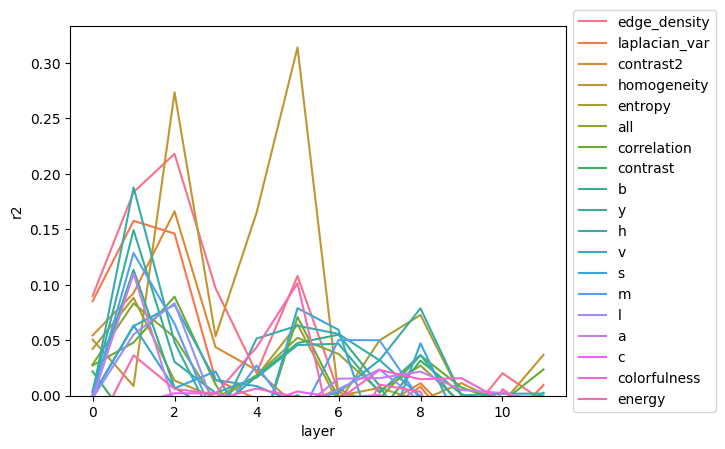

In [52]:
g = sns.lineplot(data=results, x="layer", y="r2", hue="column")
# Move legend outside
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(0, None)

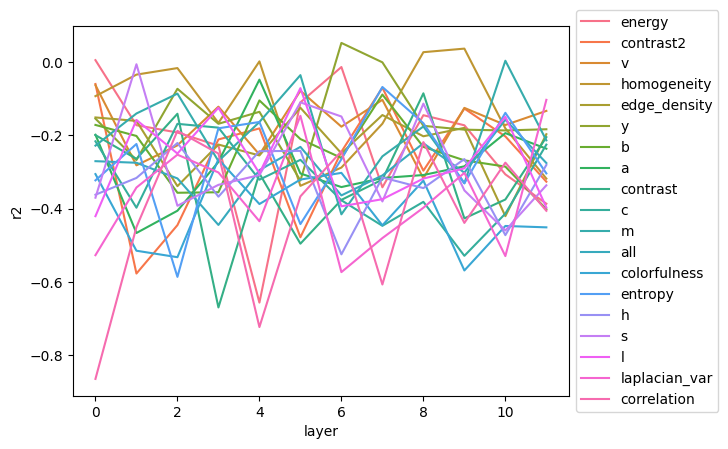

In [41]:
g = sns.lineplot(data=results, x="layer", y="r2", hue="column")
# Move legend outside
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))

<Axes: xlabel='layer', ylabel='score'>

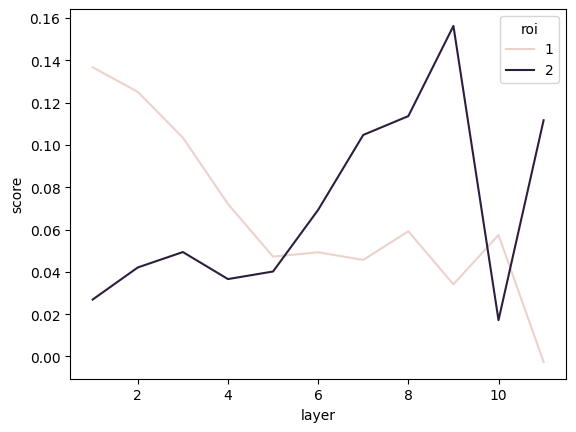

In [30]:
vision_alignment = pd.read_parquet(
    "/mnt/tecla/Results/convergence/alignments/alignment_subjects_vision_coco.parquet"
)
sns.lineplot(
    data=vision_alignment.query(
        "metric == 'rsa' and model == 'vit_base_patch16_clip_224.laion2b_pool-cls' and roi in [1,2] and layer > 0"
    )
    .groupby(["roi", "layer"])
    .score.mean()
    .reset_index(),
    x="layer",
    y="score",
    hue="roi",
)